# Ocean eddy tracking ACCESS-OM2 0.1

In [1]:
# Importing all libraries.
from pylab import *
from netCDF4 import Dataset
%matplotlib inline
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *

from xarray import *
from dask.distributed import Client
c = Client()
c

path='/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output*/ocean/ocean_daily.nc'
data=open_mfdataset(path)
#data.eta_t.mean('time')

path='/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output001/ocean/ocean_daily.nc'
data=open_dataset(path,autoclose=True)
mean=data.eta_t.mean('time')
count=0

for num in range(2,71):
    print(num)
    file='/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output%03d/ocean/ocean_daily.nc' % num
    #print(file)
    data = open_dataset(file,autoclose=True)
    mean = mean + data.eta_t.mean('time')
    #figure()
    #data.eta_t.mean('time').plot()
    #show()
    count=count+1
mean=mean/count
mean.plot()

mean.to_netcdf('/home/156/jm5970/github/trackeddy/data.input/ACCESS-OM2_01d_eta_mean.nc')

In [2]:
# Import SSHa satellite.
path="/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output001/ocean/"
ncfile=Dataset(path+'ocean_daily.nc')
ssh=squeeze(ncfile.variables['eta_t'][0:2,:,:])
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['xt_ocean'][:]
lat=ncfile.variables['yt_ocean'][:]

In [3]:

# Import SSHa satellite.
path="/home/156/jm5970/github/trackeddy/data.input/ACCESS-OM2_01d_eta_mean.nc"
ncfile=Dataset(path)
mean_ssh=squeeze(ncfile.variables['eta_t'][:,:]).data
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['xt_ocean'][:]
lat=ncfile.variables['yt_ocean'][:]

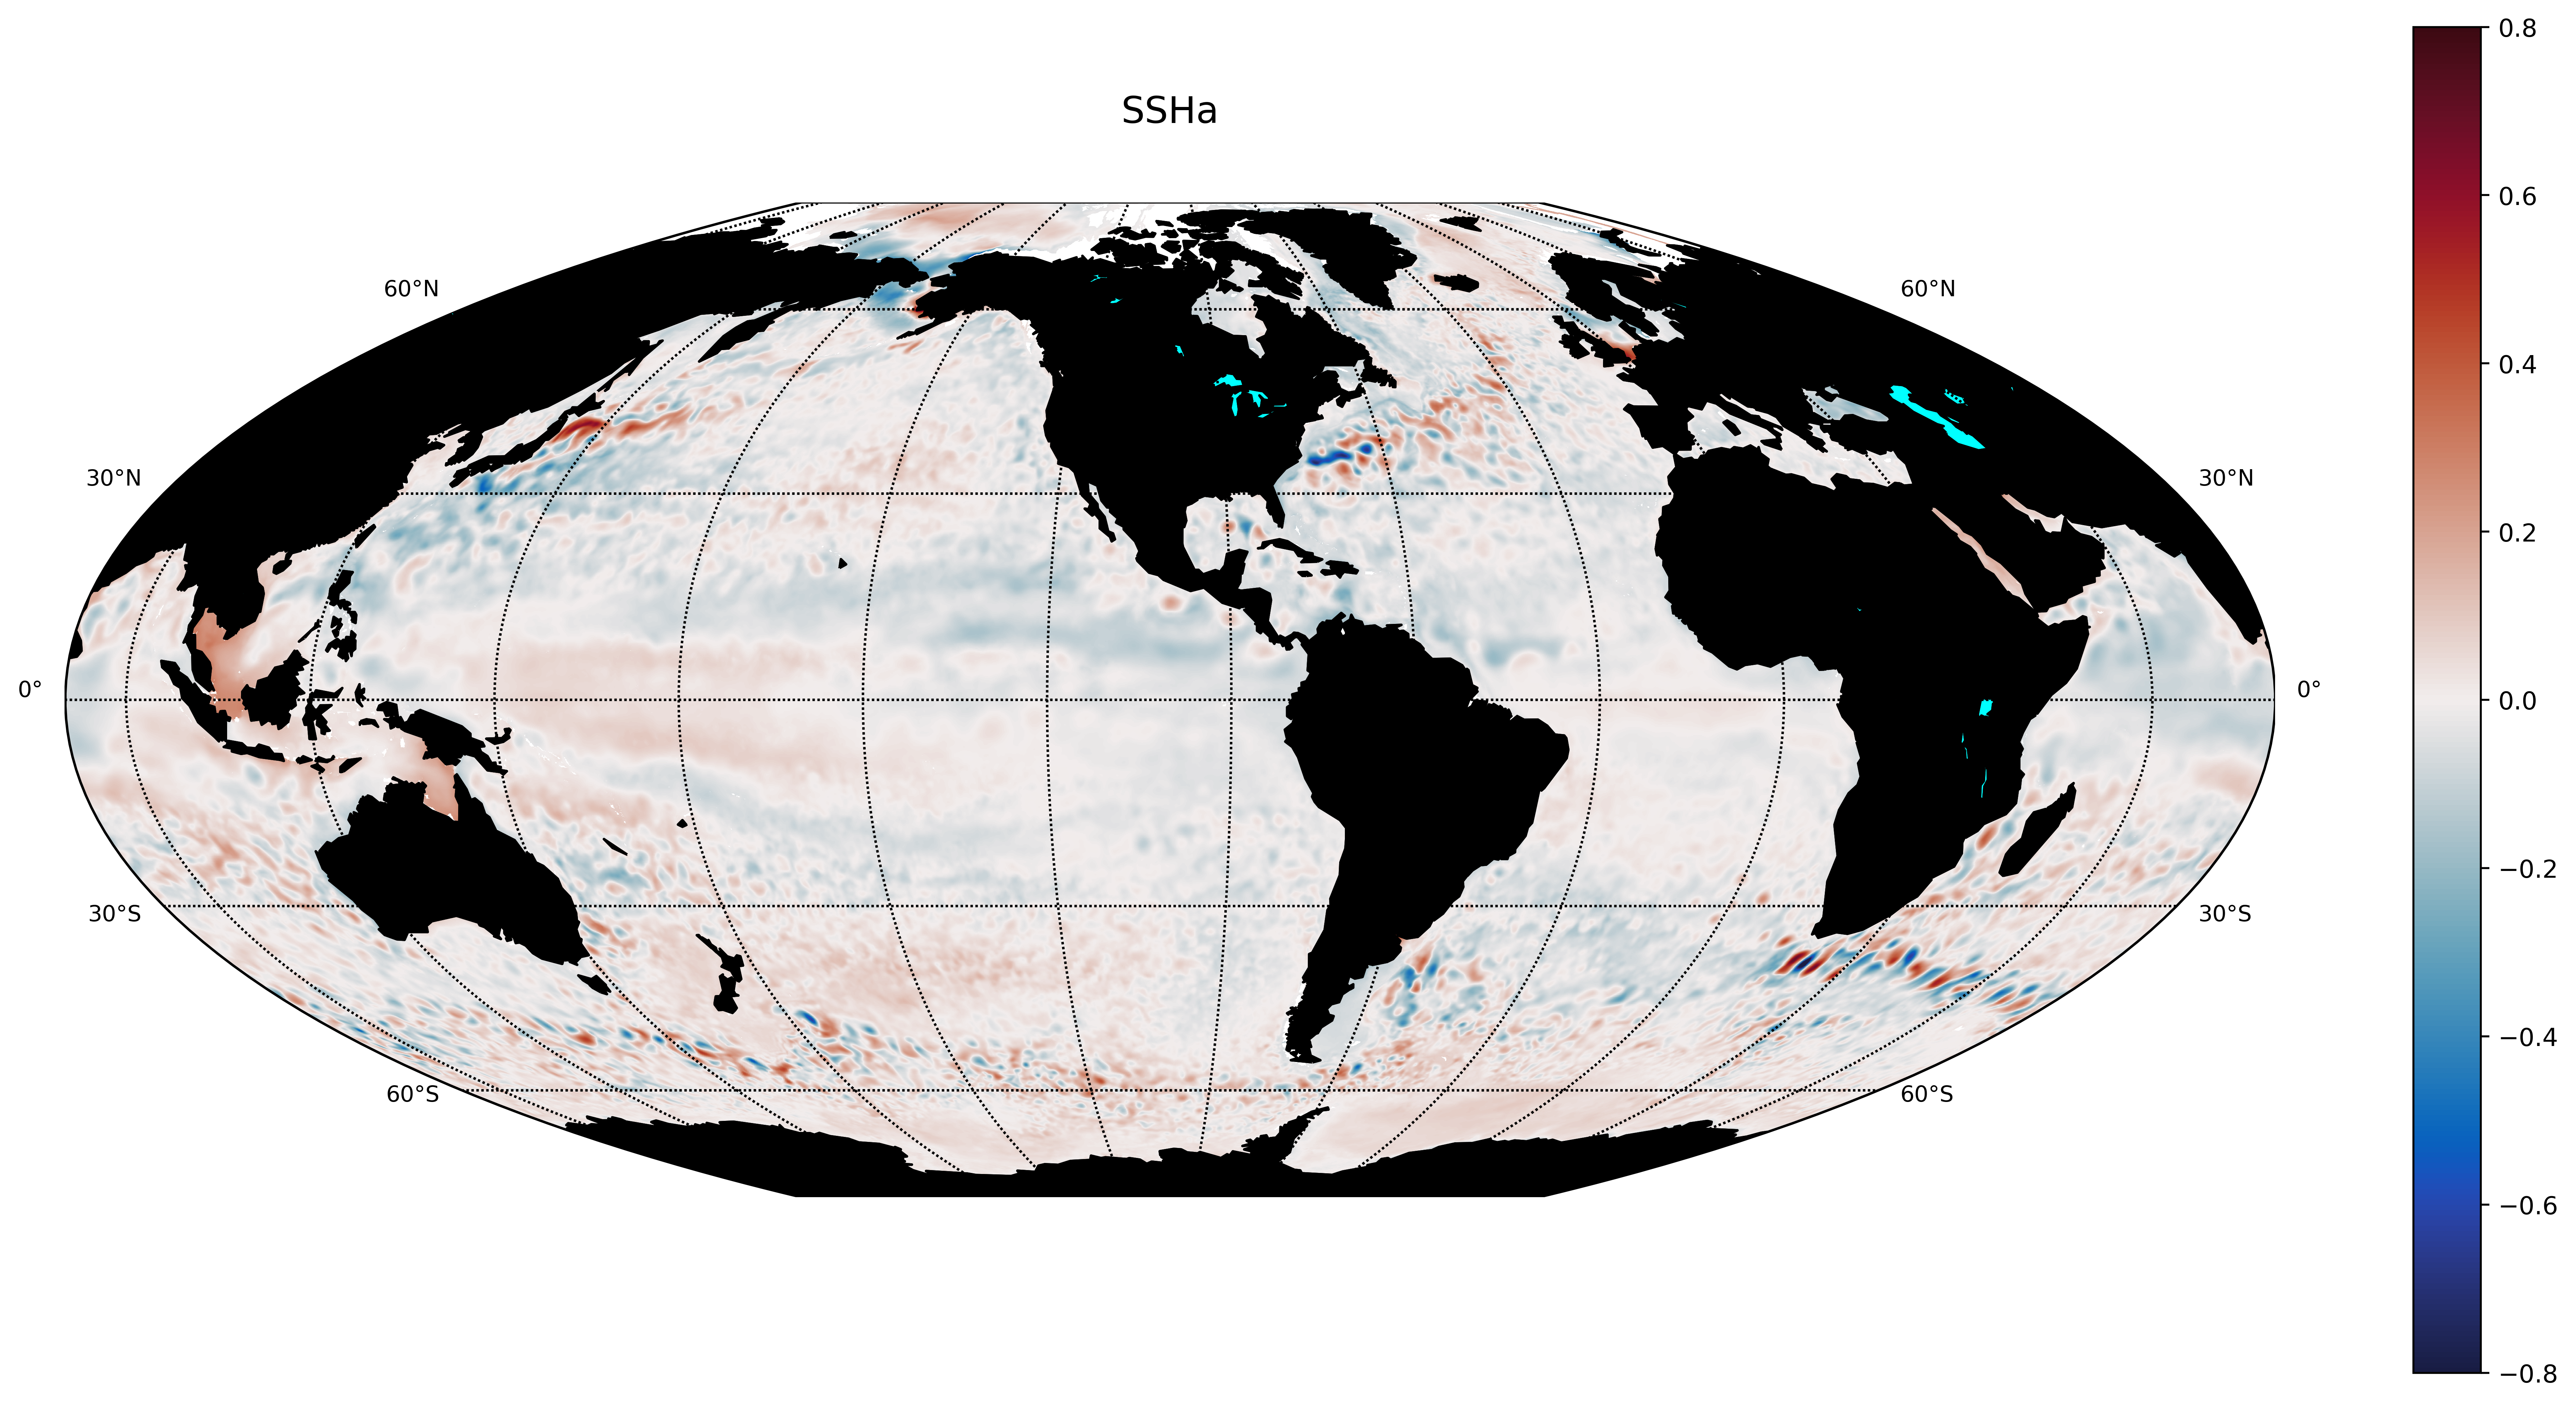

In [4]:
basemap_mplot(lon,lat,ssh[0,:,:]-mean_ssh,title="SSHa",projection='mbtfpq',lat_0=-90,lon_0=-100,\
              resolution='c',scale='Lin',vmin=-0.8,vmax=0.8,cmap=cm.cm.balance,xan=1,yan=1,\
              figsize=(20,10),fontsize=15,dpi=500)
colorbar()

(<matplotlib.figure.Figure at 0x7ff0ff7c6be0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0df217b70>,
       dtype=object))

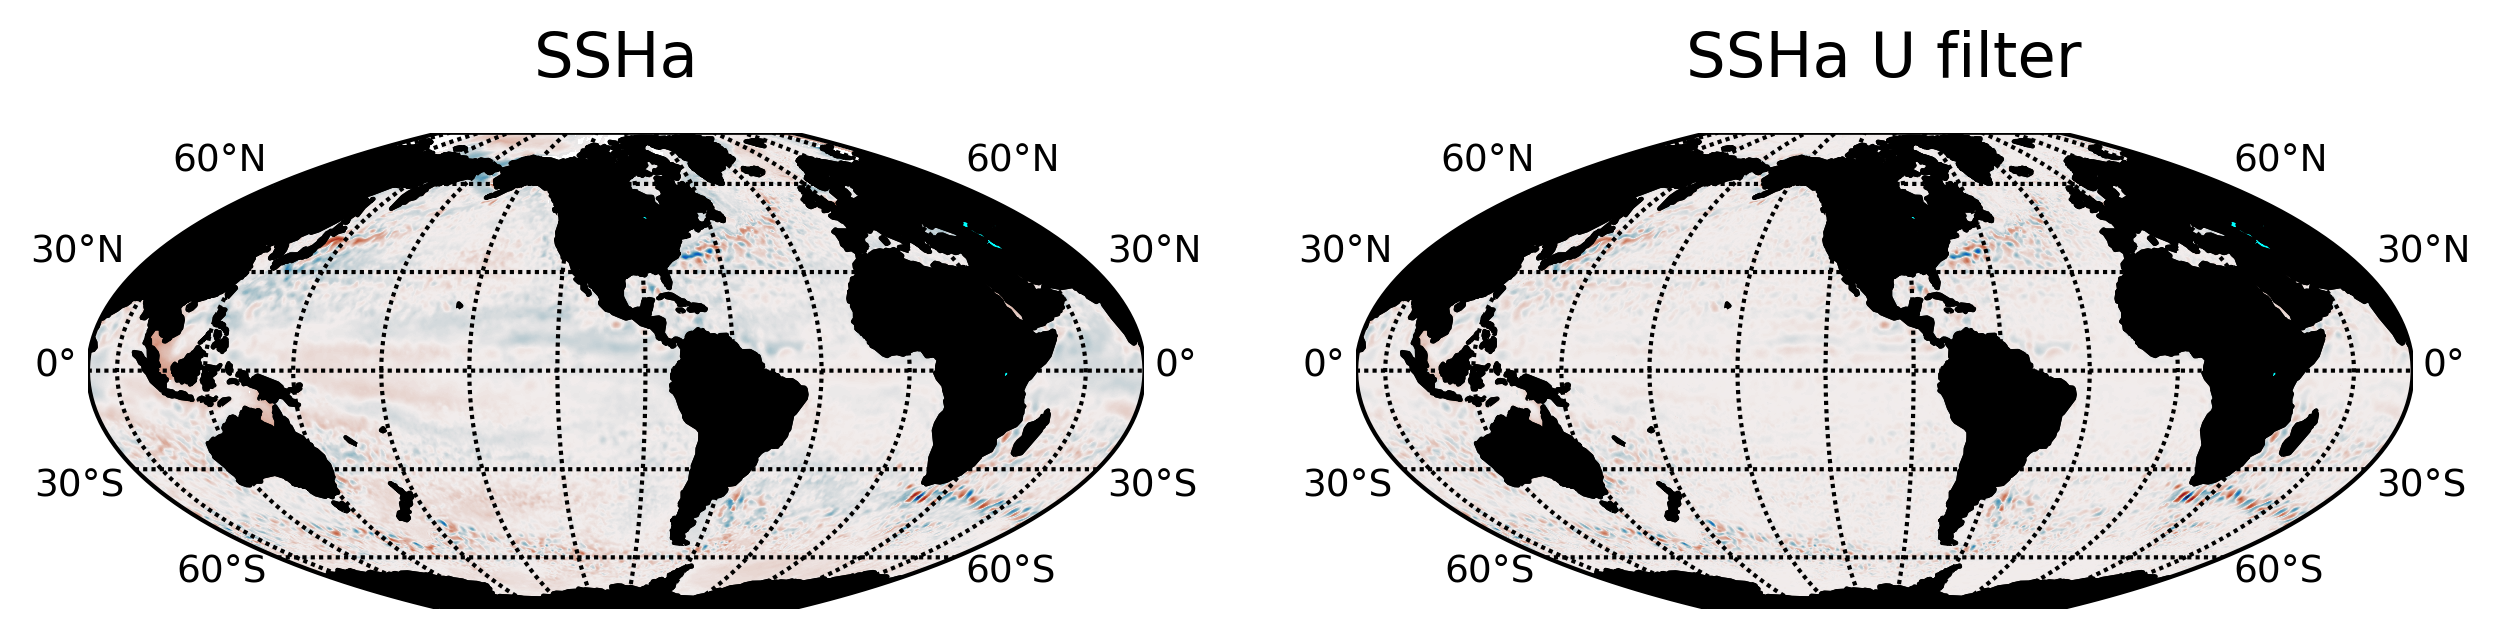

In [5]:
#Area in indexes, probably in the future it will be added an option for lon - lat coords.

#500:1500,0:300

nofilterdata=ssh[0,:,:]-mean_ssh
nofilterdata=nofilterdata.filled(fill_value=0)
nofilterdata = nofilterdata - ndimage.uniform_filter(nofilterdata, size=70)

#data = ma.masked_array(nofilterdata, mask)
basemap_mplot(lon,lat,[ssh[0,:,:]-mean_ssh,nofilterdata],title=["SSHa","SSHa U filter"]\
              ,projection='mbtfpq',lat_0=-90,lon_0=-100,scale='Lin',cmap=cm.cm.balance\
              ,vmin=-1,vmax=1,xan=2,yan=1,figsize=(10,5),fontsize=15,dpi=300)

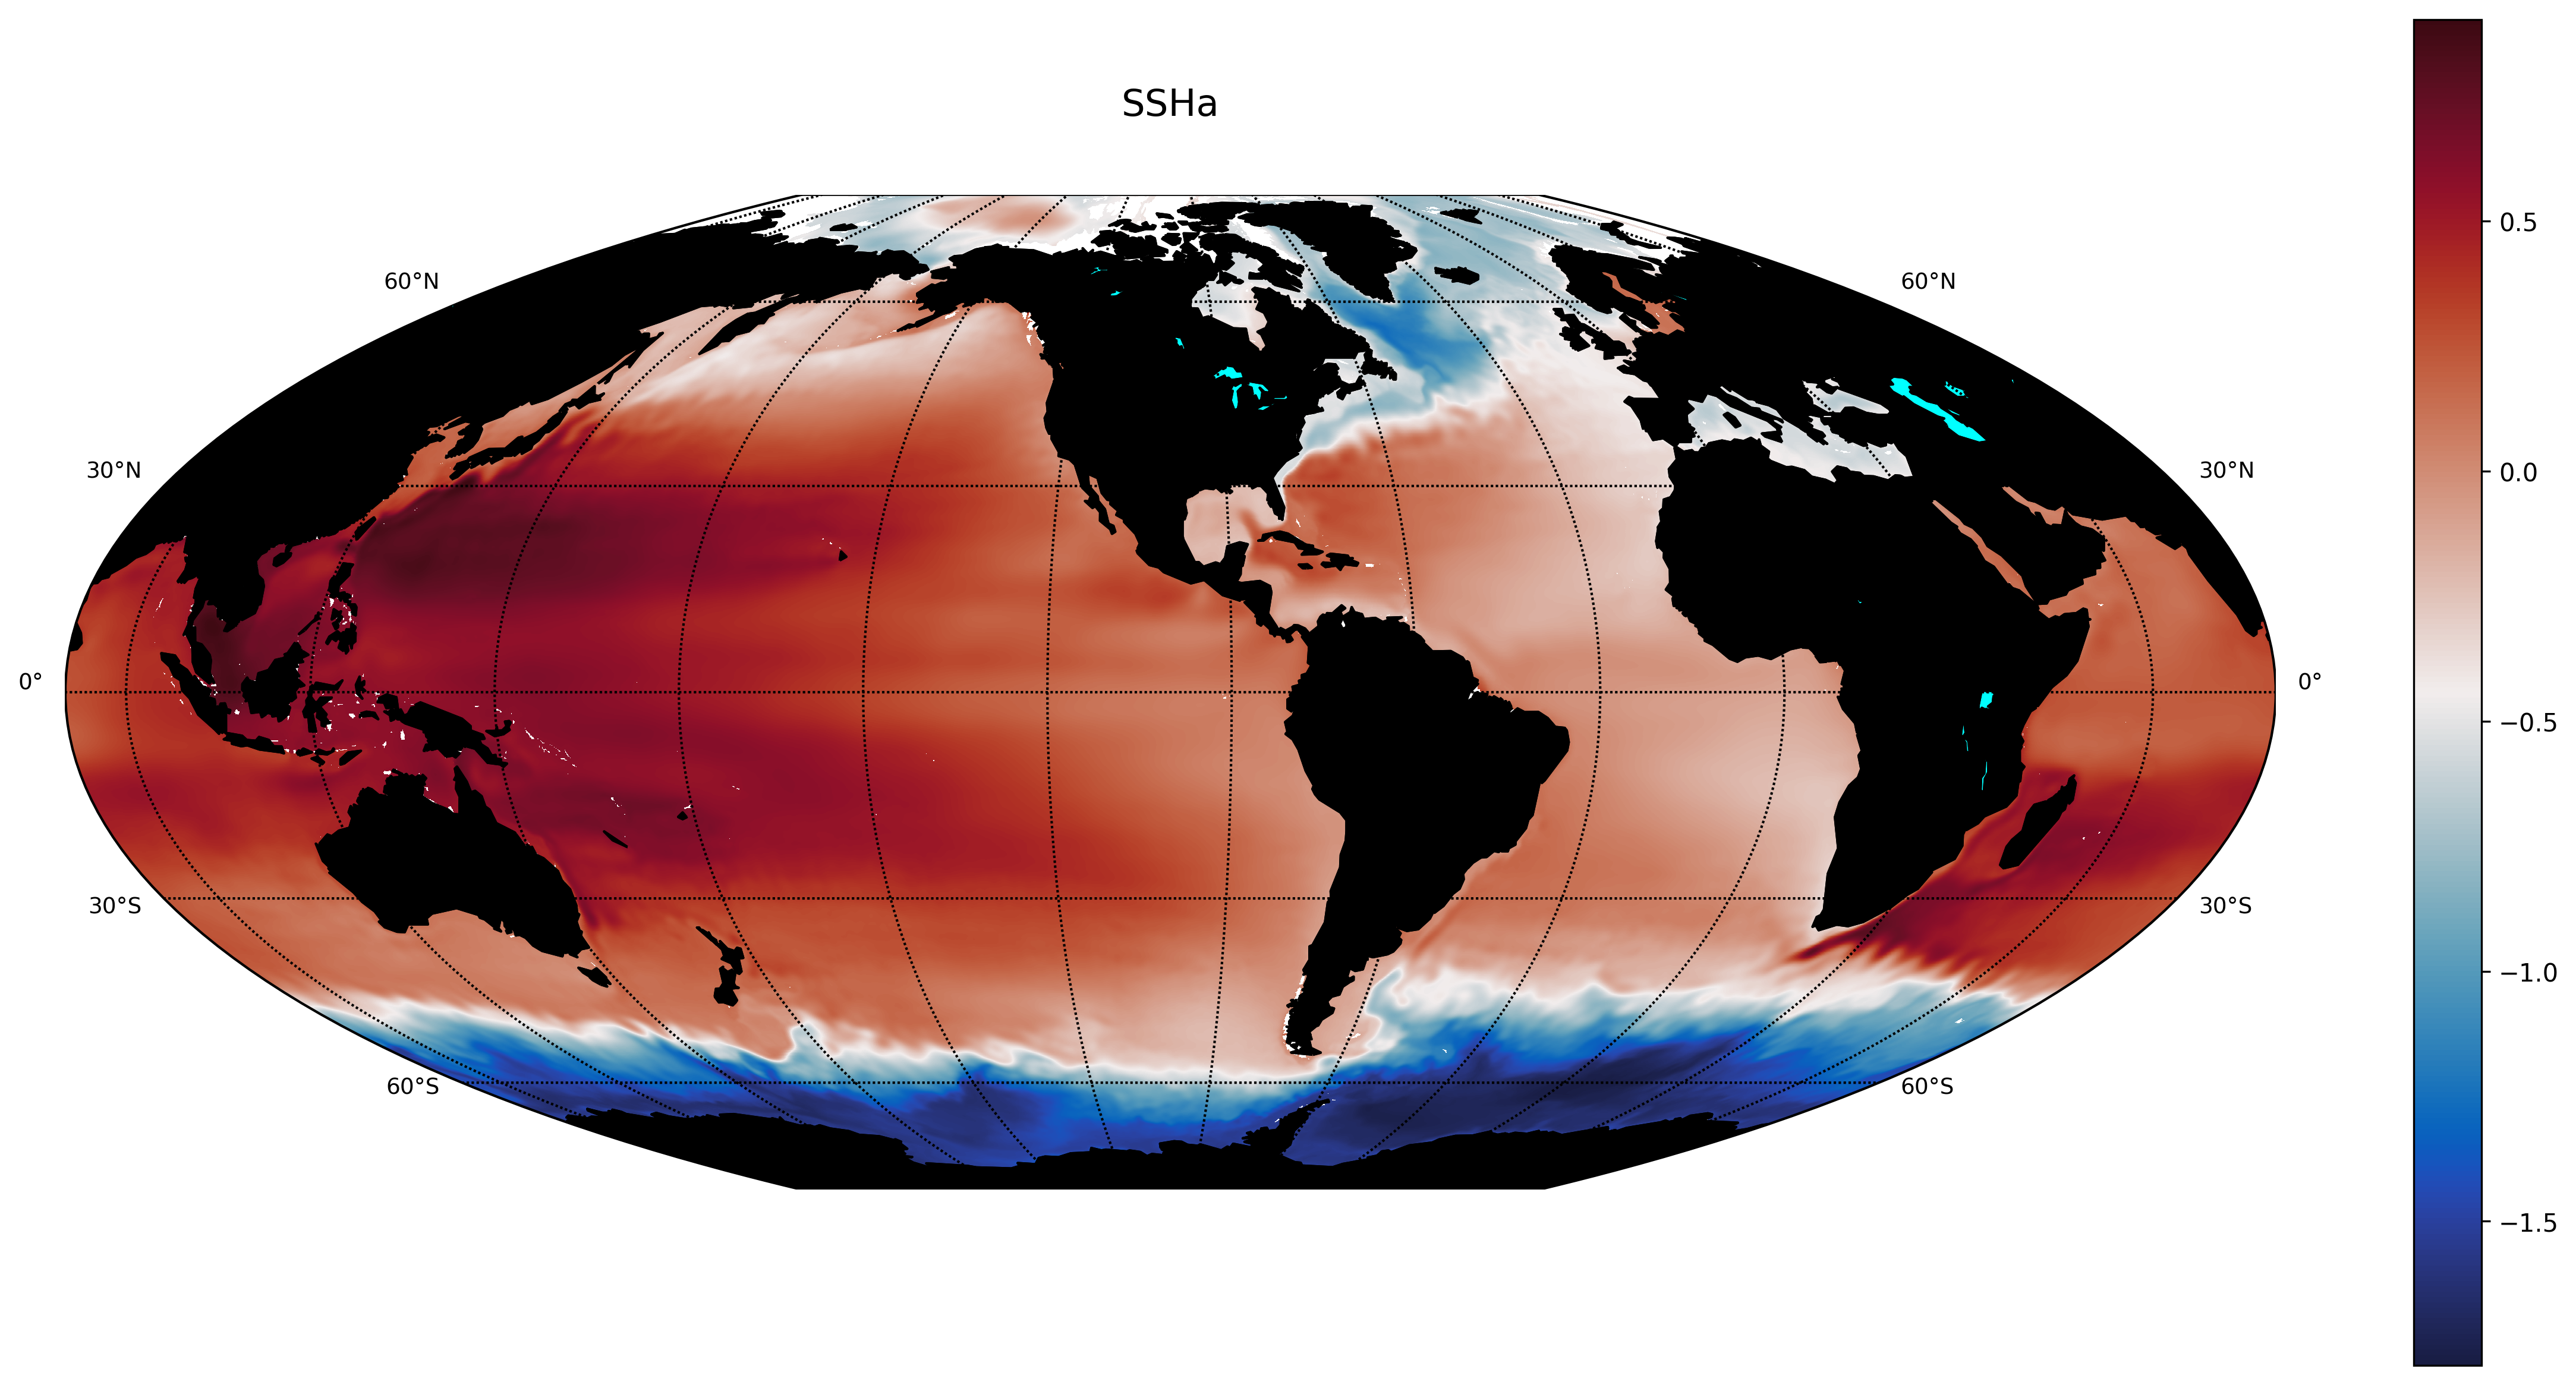

In [6]:
basemap_mplot(lon,lat,ssh[0,:,:]-nofilterdata,title="SSHa",projection='mbtfpq',lat_0=-90,lon_0=-100,\
              resolution='c',scale='Lin',vmin='',vmax='',cmap=cm.cm.balance,xan=1,yan=1,\
              figsize=(20,10),fontsize=15)
colorbar()

In [7]:
#Area in indexes, probably in the future it will be added an option for lon - lat coords.
#areamap=array([[0,int(len(lon))],[200,int(len(lat)/3)]])
areamap=array([[0,int(len(lon))],[0,int(len(lat)/3)]])

In [ ]:
eddytd=analyseddyzt(ssh[:,:,:],lon,lat,0,1,1,ssh[:,:,:].max(),0.01,0.01,data_meant=mean_ssh.data,areamap=areamap,mask=''\
                     #,eccenfit=0.5,gaussrsquarefit=0.9,ellipsrsquarefit=0.9\
                     ,maskopt='contour',sfilter='uniform',sfsize=70\
                     ,destdir='',physics='',diagnostics=False,plotdata=False,pprint=True)

 0% [====================>]100% | Elapsed Time: 0 s | Estimated Time: 0 s | Info: Init time |
 0% [====================>]100% | Elapsed Time: 73 s | Estimated Time: 73 s | Info: 0 |0 |

In [ ]:
eddysplot=reconstruct_syntetic(shape(ssh),lon,lat,eddytd)
del eddytd

In [ ]:
eddytdn=analyseddyzt(ssh[:,:,:],lon,lat,0,1,1,ssh[:,:,:].min(),-0.01,-0.01,data_meant=mean_ssh.data,areamap=areamap,mask=''\
                     #,eccenfit=0.5,gaussrsquarefit=0.9,ellipsrsquarefit=0.9\
                     ,maskopt='contour',sfilter='uniform',sfsize=70\
                     ,destdir='',physics='',diagnostics=False,pprint=True)

In [ ]:
eddysplotn=reconstruct_syntetic(shape(ssh),lon,lat,eddytdn)
del eddytdn

In [ ]:
basemap_mplot(lon,lat,[ssh[0,:,:]-mean_ssh,ssh[0,:,:]-mean_ssh-eddysplot[0,:,:]-eddysplotn[0,:,:],eddysplotn[0,:,:],eddysplot[0,:,:]]\
              ,title=["SSHa","Eddies extraction","Negative Eddies extraction","Positive Eddies extraction"]\
              ,projection='mbtfpq',lat_0=-90,lon_0=-100,scale='Lin',cmap=cm.cm.balance,\
              vmin=-.40,vmax=.40,xan=2,yan=2,figsize=(20,10),fontsize=20);

In [ ]:
mask=ma.getmask(ssh[0,:,:])

In [ ]:
u_g,v_g=geovelfield(ssh[0,:,:],lon,lat,mask,5)
plt.pcolormesh(u_g,vmin=0,vmax=0.1)
print(nanmax(u_g),nanmax(v_g))

In [ ]:
eddyu,eddyv=geovelfield(eddysplotn[0,:,:]+eddysplot[0,:,:],lon,lat,mask,5)

In [ ]:
ke=KE(u_g,v_g)
eke=KE(eddyu,eddyv)
bjke=ke-eke#KE(u_g-eddyu,v_g-eddyv)

print(mean(ke),mean(bjke),mean(eke))

In [ ]:
basemap_mplot(lon,lat,[ke,bjke,eke]\
              ,title=["KE","B&J KE","EKE"],scale='Lin',cmap=cm.cm.tempo,\
              projection='mbtfpq',lat_0=-90,lon_0=-100,vmin=0,vmax=0.2,xan=3,yan=1,figsize=(20,30),fontsize=20);

In [ ]:
print(mean(ke))
print(mean(bjke))
print(mean(eke))

In [ ]:
basemap_mplot(lon,lat,ke-eke\
              ,title="BKE",scale='Lin',cmap=cm.cm.tempo,\
              projection='mbtfpq',lat_0=-90,lon_0=-100,vmin=0,vmax=0.2,xan=1,yan=1,figsize=(20,10),fontsize=20);
colorbar()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

fig = plt.figure(figsize=(15, 10),facecolor='white')
gs = gridspec.GridSpec(1, 1)

#############################

ax1 = plt.subplot(gs[0,0])

lonmm,latmm=np.meshgrid(lon,lat)
#############################
#Plot the background and other things, This will be in all the frames
map = Basemap(projection='mbtfpq',lat_0=-90,lon_0=-180,resolution='c',ax=ax1)
lonm,latm=map(lonmm,latmm)
map.drawmeridians(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
map.drawparallels(np.arange(0,360,30),labels=[1,1,0,0],fontsize=10)
map.fillcontinents(color='black',lake_color='aqua')
map.drawcoastlines()
map.drawcoastlines()
quad1 = ax1.pcolormesh(lonm,latm,eke[0,:,:],shading='gouraud',cmap=cm.cm.tempo,\
              vmin=0,vmax=0.2)
cb1 = fig.colorbar(quad1,ax=ax1)
##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    return quad1
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(eke[iter,:,:].ravel())
    return quad1
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=30,interval=1000,blit=False,repeat=False)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2



In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# #Save animation
anim2.save('../output/eke_30days_ecc0-08_1axis.mp4', writer=writer)